In [1]:
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import precision_recall_curve, accuracy_score, confusion_matrix
from pyarrow.feather import read_feather
import matplotlib.pyplot as plt
import pandas as pd
import sys
import sklearn
import numpy as np
import xlsxwriter

%matplotlib inline

In [2]:
sys.path.append("F:\Valentina\Experiments\exp_lookback\mylib")
import cv_toolkit as mycv

In [3]:
def get_cols(df, stem):
    return [col for col in list(df) if stem in col]

def cut_lookback(x, max_days):
    return x.where(x <= max_days, np.nan)

def cut_df(df, yrs):
    df_tmp = df.copy()
    for col in list(df):
        df_tmp[col] = cut_lookback(df_tmp[col], 365*yrs)
    return df_tmp

def cv_imp_feature(cv_outputs, f_cols):
    feature_imp = pd.DataFrame()
    feature_imp['Feature'] = f_cols
    for i in range(len(cv_outputs['models'])):  
        col = 'Fold_' + str(i)
        feature_imp[col] = cv_outputs['models'][i].feature_importances_
    feature_imp['Mean_score'] = feature_imp.iloc[:,1:].mean(axis=1)
    feature_imp.sort_values(by= 'Mean_score', axis = 0, ascending = False, inplace =True)
    feature_imp = feature_imp.reset_index(drop = True)
    return feature_imp

In [4]:
#set parameters
filename = file_abb = "F:\\Projects\\AbbVie_SCLC\\data\\modelling_data\\03_training_reduced_features.csv"
last_exp_stem = 'LAST_EXP'
label = "OUTCOME"
pos_label = 1
neg_label = 0

In [5]:
#select columns from dataset
df = pd.read_csv(filename)
exp_cols = get_cols(df, last_exp_stem)
cols = exp_cols + [label]
df = df[cols]

In [6]:
#no need to change the ratio in this case
df[label].value_counts()

0    3377
1    1665
Name: OUTCOME, dtype: int64

In [7]:
#using sklearn methods
model = XGBClassifier()
kfold = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True)
results = cross_val_score(estimator = model,
                          X = df[exp_cols], 
                          y = df[label], 
                          cv = kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 81.83% (1.60%)


In [8]:
#using Shaun library for cv
#model = XGBClassifier(n_estimators = 50)
model = XGBClassifier
kfold = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True)
cv_outputs = mycv.run_CV(X = df[exp_cols], 
                         y = df[label], 
                         clf_class = model,
                         cv_method=kfold,
                         flatten=True)

Running fold  1  ...
Running fold  2  ...
Running fold  3  ...
Running fold  4  ...
Running fold  5  ...


In [9]:
eval_metrics = [precision_recall_curve, accuracy_score, confusion_matrix]
output_metrics ={}
output_metrics['All'] = mycv.calc_CV_metrics(**cv_outputs['predictions']['test'],
                                            metrics=eval_metrics, models=cv_outputs['models'],
                                            feature_names=exp_cols)

Text(0,0.5,'Precision')

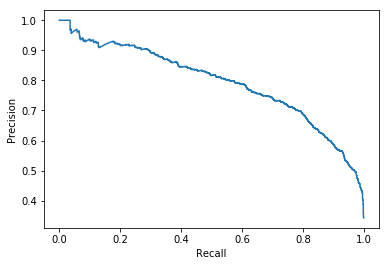

In [10]:
pd.DataFrame.from_dict(output_metrics['All']['precision_recall_curve']).plot(x='recall', y='precision', legend=False)
plt.xlabel('Recall')
plt.ylabel('Precision')

## Running models on different lookback cut offs

In [16]:
df[exp_cols].max().max()/365

2.2794520547945205

In [17]:
#performing loop on different selection of features
output_metrics ={}
feature_imp = {}
model = XGBClassifier
kfold = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True)
#params = {'n_estimators': 50}
model_features = {'2 yrs': 2, '1yr': 1, '6 mo': 0.5, '3 mo': 0.25, '1 mo': 1/12, '1 d': 1/365 }

for model_name, looklength in model_features.items():
    print(model_name)
    print("Computing dataframe...")
    modelling_data = cut_df(df, looklength)
    print("Running crossvalidation...")
    cv_outputs = mycv.run_CV(X = modelling_data[exp_cols], 
                         y = modelling_data[label], 
                         clf_class = model,
                         cv_method=kfold,
                         flatten=True)
    print("Computing metrics...")
    output_metrics[model_name] = mycv.calc_CV_metrics(**cv_outputs['predictions']['test'],
                                            metrics=eval_metrics, models=cv_outputs['models'],
                                            feature_names=exp_cols)
    print("Computing feature importance...")
    feature_imp[model_name] = mycv.calc_imp_feature(cv_outputs, exp_cols)

2 yrs
Computing dataframe...
Running crossvalidation...
Running fold  1  ...
Running fold  2  ...
Running fold  3  ...
Running fold  4  ...
Running fold  5  ...
Computing metrics...
Computing feature importance...
1yr
Computing dataframe...
Running crossvalidation...
Running fold  1  ...
Running fold  2  ...
Running fold  3  ...
Running fold  4  ...
Running fold  5  ...
Computing metrics...
Computing feature importance...
6 mo
Computing dataframe...
Running crossvalidation...
Running fold  1  ...
Running fold  2  ...
Running fold  3  ...
Running fold  4  ...
Running fold  5  ...
Computing metrics...
Computing feature importance...
3 mo
Computing dataframe...
Running crossvalidation...
Running fold  1  ...
Running fold  2  ...
Running fold  3  ...
Running fold  4  ...
Running fold  5  ...
Computing metrics...
Computing feature importance...
1 mo
Computing dataframe...
Running crossvalidation...
Running fold  1  ...
Running fold  2  ...
Running fold  3  ...
Running fold  4  ...
Running f

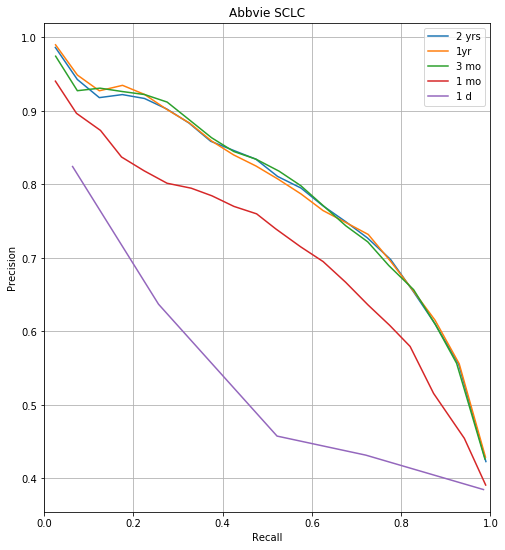

In [62]:
plt.figure(figsize = (8,9))
bins = np.arange(0,1.05,0.05)
#for model in output_metrics.keys():
for model in ['2 yrs', '1yr', '3 mo', '1 mo', '1 d']:
    pr = pd.DataFrame.from_dict(output_metrics[model]['precision_recall_curve'])
    if model == '1 d':
        bins = bins = np.arange(0,1.2,0.2)
    binned_pr = pr.groupby(pd.cut(pr['recall'], bins = bins)).mean()
    plt.plot(binned_pr['recall'], binned_pr['precision'], label = model)

plt.title('Abbvie SCLC')
plt.grid()
plt.xlim(0,1.0)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [54]:
workbook = pd.ExcelWriter('Abbvie_SCLC.xlsx', engine = 'xlsxwriter')
bins = np.arange(0,1.02,0.02)
for model in ['2 yrs', '1yr', '3 mo', '1 mo', '1 d']:
    pr = pd.DataFrame.from_dict(output_metrics[model]['precision_recall_curve'])
    pr = pd.DataFrame.from_dict(output_metrics['2 yrs']['precision_recall_curve'])
    binned_df = pr.groupby(pd.cut(pr['recall'], bins = bins)).mean()
    binned_df.reset_index(drop=True).to_excel(workbook, sheet_name= model)
workbook.save()

In [23]:
set(feature_imp['2 yrs'].head(10)['Feature']) - set(feature_imp['6 mo'].head(10)['Feature'])

{'PR21_LAST_EXP_DT'}